In [1]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 63.7MB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 163MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

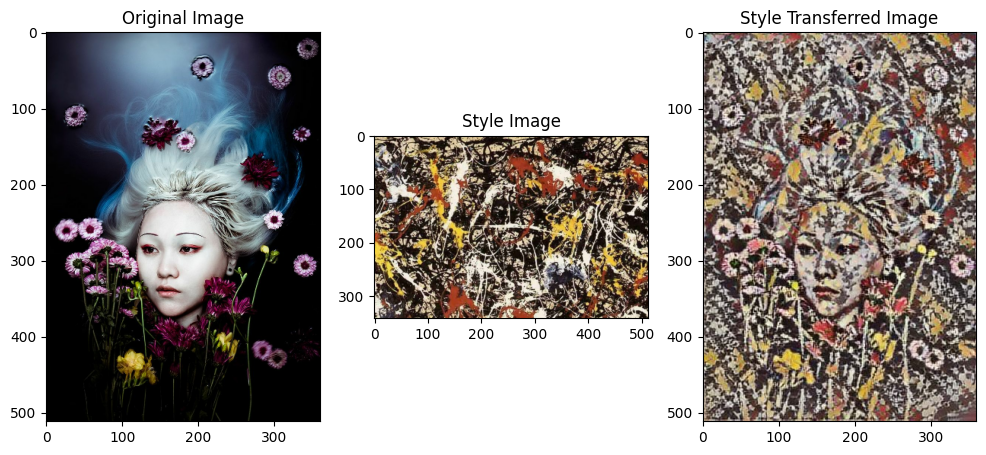

In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import cv2
from lpips import LPIPS
from PIL import Image
import requests
from io import BytesIO

# Set TensorFlow Hub to load compressed models
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Set matplotlib for visualization
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

# Helper functions

def tensor_to_image_for_style(tensor):
    """
    Converts a Tensor to an image for style transfer.
    This function rescales tensor values to [0, 255] for image display.
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def tensor_to_image_for_optimization(tensor, original_size):
    """
    Converts a tensor back to an image with the same size as the original.
    This function also denormalizes the image tensor and resizes it.
    """
    tensor = tensor.squeeze(0).cpu().detach()
    tensor = tensor.permute(1, 2, 0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    tensor = tensor.clamp(0, 1)
    tensor = tensor.numpy()
    return Image.fromarray((tensor * 255).astype('uint8')).resize(original_size, Image.Resampling.LANCZOS)

def load_img(path_to_img, max_dim=512):
    """
    Load an image from a file and resize it to the given maximum dimension.
    """
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    """
    Display a Tensor image with an optional title.
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def preprocess_image(image_path, size=None):
    """
    Preprocess the image for use in PyTorch models. Normalizes and resizes the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = apply_unsharp_mask(img)
    img = apply_bilateral_filter(img)

    if size:
        img = img.resize(size, Image.Resampling.LANCZOS)

    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0).cuda()
    return img_tensor, img.size

def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    image_np = np.array(image)
    filtered = cv2.bilateralFilter(image_np, d, sigma_color, sigma_space)
    return Image.fromarray(filtered)

def apply_unsharp_mask(image, strength=0.5):
    image_np = np.array(image)
    blurred = cv2.GaussianBlur(image_np, (9, 9), 10.0)  # Smooth the image
    sharpened = cv2.addWeighted(image_np, 1 + strength, blurred, -strength, 0)
    return Image.fromarray(sharpened)

def extract_descriptors(image_tensor, method='ORB', size=None):
    """
    Extract ORB or SIFT descriptors from a tensor image.
    """
    image_np = tensor_to_image_for_optimization(image_tensor, size)  # Convert tensor to PIL image
    gray_image = cv2.cvtColor(np.array(image_np), cv2.COLOR_RGB2GRAY)
    if method == 'ORB':
        detector = cv2.ORB_create()
    elif method == 'SIFT':
        detector = cv2.SIFT_create()
    else:
        raise ValueError("Method should be 'ORB' or 'SIFT'")

    keypoints, descriptors = detector.detectAndCompute(gray_image, None)
    return descriptors

def match_descriptors(des1, des2, method='ORB', ratio_test=0.75):
    """
    Match descriptors between two images using BFMatcher and return the number of good matches.
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False) if method == 'ORB' else cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Match descriptors using KNN
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to filter matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)

    return good_matches

# Load models
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
vgg = torchvision.models.vgg19(pretrained=True).features.eval().cuda()
lpips_model = LPIPS(net='vgg').cuda()

# Load and display content and style images
content_image_path = "input_image.jpg"
style_image_path = "style_image.jpg"
# style_url = "https://theartiz.ai/wp-content/uploads/2024/06/ec4-scaled.jpg"  # Replace with any style image
# style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/640px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"  # Replace with any style image
# style_image_path = tf.keras.utils.get_file('cubism.jpg','https://theartiz.ai/wp-content/uploads/2024/06/ec4-scaled.jpg')
# style_image_path = tf.keras.utils.get_file('starry_night.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/640px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
content_image = load_img(content_image_path)
style_image = load_img(style_image_path)

# Apply style transfer
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
stylized_image_pil = tensor_to_image_for_style(stylized_image)

# Save style-transferred image
output_path = "stylized_image.jpg"
stylized_image_pil.save(output_path)

plt.subplot(1, 3, 1)
imshow(content_image, 'Original Image')

plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
imshow(load_img("stylized_image.jpg"), 'Style Transferred Image')

Step 0, Feature Loss: 491.0168762207031, LPIPS Loss: 0.022821718826889992, ORB Match: 488.00, SIFT Match: 2565.00, Total Loss: 796.31689453125
Step 100, Feature Loss: 96.32874298095703, LPIPS Loss: 0.28074172139167786, ORB Match: 453.00, SIFT Match: 1966.00, Total Loss: 338.40948486328125
Step 200, Feature Loss: 65.83734130859375, LPIPS Loss: 0.29728254675865173, ORB Match: 444.00, SIFT Match: 1901.00, Total Loss: 300.5346374511719
Step 300, Feature Loss: 53.7207145690918, LPIPS Loss: 0.30515164136886597, ORB Match: 442.00, SIFT Match: 1856.00, Total Loss: 283.72589111328125
Step 400, Feature Loss: 47.12434768676758, LPIPS Loss: 0.3100721538066864, ORB Match: 432.00, SIFT Match: 1797.00, Total Loss: 270.23443603515625
Step 500, Feature Loss: 42.681095123291016, LPIPS Loss: 0.3130215108394623, ORB Match: 432.00, SIFT Match: 1772.00, Total Loss: 263.29412841796875
Step 600, Feature Loss: 39.179351806640625, LPIPS Loss: 0.31617140769958496, ORB Match: 428.00, SIFT Match: 1777.00, Total Lo

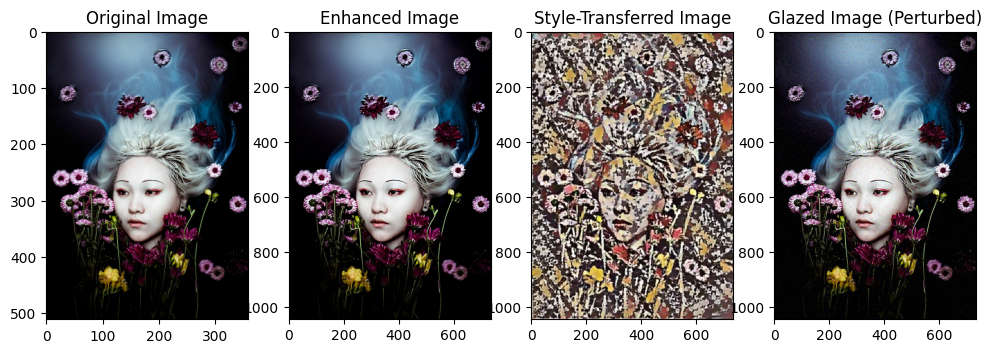

Image saved as glazed_image.jpg


In [3]:
# Function to optimize perturbation based on descriptors
def optimize_perturbation_with_descriptors(original_image, style_transferred_image, alpha=1.0, beta_orb=0.1, beta_sift=0.1, p=0.1, max_iter=1000):
    """
    Optimize the perturbation applied to the original image to match the style-transferred image.
    """
    perturbation = torch.randn_like(original_image, requires_grad=True).cuda() * 0.01
    perturbation = perturbation.detach().requires_grad_(True)
    optimizer = optim.Adam([perturbation], lr=0.01)

    for step in range(max_iter):
        optimizer.zero_grad()

        # Feature space loss (VGG)
        original_features = vgg(original_image + perturbation)
        style_features = vgg(style_transferred_image)
        feature_loss = torch.norm(original_features - style_features, p=2)

        # Perceptual similarity loss (LPIPS)
        lpips_loss = lpips_model(original_image + perturbation, original_image)

        # ORB Descriptor Matching Loss (minimize matches)
        original_des = extract_descriptors(original_image, 'ORB', original_size)
        perturbed_des = extract_descriptors(original_image + perturbation, 'ORB', original_size)

        orb_matches = match_descriptors(original_des, perturbed_des, method='ORB')
        orb_match = len(orb_matches)  # We want to minimize the number of matches

        # SIFT Descriptor Matching Loss (minimize matches)
        perturbed_des = extract_descriptors(original_image + perturbation, 'SIFT', original_size)
        original_des = extract_descriptors(original_image, 'SIFT', original_size)

        sift_matches = match_descriptors(original_des, perturbed_des, method='SIFT')
        sift_match = len(sift_matches)  # We want to minimize the number of matches

        # Total loss
        total_loss = (
            + alpha * feature_loss
            + alpha * torch.max(lpips_loss - p, torch.tensor(0.0).cuda())
            + beta_orb * orb_match
            + beta_sift * sift_match
        )

        if step % 100 == 0:
            print(f"Step {step}, Feature Loss: {feature_loss.item()}, LPIPS Loss: {lpips_loss.item()}, ORB Match: {orb_match:.2f}, SIFT Match: {sift_match:.2f}, Total Loss: {total_loss.item()}")

        total_loss.backward()
        optimizer.step()

    return original_image + perturbation


# Preprocess images for optimization
original_image, original_size = preprocess_image(content_image_path)
style_transferred_image, _ = preprocess_image("stylized_image.jpg", size=original_size)

# Optimize perturbation and visualize the results
perturbed_image = optimize_perturbation_with_descriptors(original_image, style_transferred_image)

original_image_np = tensor_to_image_for_optimization(original_image, original_size)
style_transferred_image_np = tensor_to_image_for_optimization(style_transferred_image, original_size)
perturbed_image_np = tensor_to_image_for_optimization(perturbed_image, original_size)

plt.subplot(1, 4, 1)
imshow(content_image)
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(original_image_np)
plt.title("Enhanced Image")

plt.subplot(1, 4, 3)
plt.imshow(style_transferred_image_np)
plt.title("Style-Transferred Image")

plt.subplot(1, 4, 4)
plt.imshow(perturbed_image_np)
plt.title("Glazed Image (Perturbed)")

plt.show()

# Save the perturbed image
def save_image(tensor, filename="perturbed_image.jpg"):
    """
    Save the perturbed image to a file after converting it from tensor to PIL.
    """
    pil_image = tensor_to_image_for_optimization(tensor, original_size)
    pil_image.save(filename)
    print(f"Image saved as {filename}")

save_image(perturbed_image, "glazed_image.jpg")
